In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


#### Importing the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import shap
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import plotly.express as px
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean
from sklearn.model_selection import train_test_split

# selection of algorithms to consider and set performance measure
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV, GridSearchCV, ShuffleSplit, KFold, cross_validate

In [4]:
# Defining the column names. 
columns = ['Age','Workclass','fnlgwt','Education','Education Num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Country','Above/Below 50K']

In [5]:
train_df = pd.read_csv('adult-training.csv',names=columns,na_values='?',header=None,sep=', ')
test_df = pd.read_csv('adult-test.csv',names=columns,na_values='?',header=None,sep=', ')

In [6]:
train_df.shape # The training census data has information about income details for 32,561 people.

(32561, 15)

In [7]:
test_df.shape # The test census data has information about income details for 16,282 people.

(16282, 15)

In [8]:
# Let us combine the dataset for a precise EDA & data preprocessing
datasets = [train_df, test_df]
df_1 = pd.concat(datasets)
df_1.shape

(48843, 15)

In [9]:
# In trained data the target variable has 2 components (<=50K & >50K) while in test data it has 2 values (<=50K. & >50K.)
# Hence doing this value replacement for better understanding.

df_1['Above/Below 50K'] = df_1['Above/Below 50K'].str.replace('<=50K.', '<=50K')
df_1['Above/Below 50K'] = df_1['Above/Below 50K'].str.replace('>50K.', '>50K')

In [10]:
df_1.head(2)

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Above/Below 50K
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K


In [11]:
df = df_1.copy()

In [12]:
df.columns = [ column.lower().replace(" ", "_").replace("/", "_") for column in df.columns]

In [13]:
df.info() # Checking the desired data types of the given features.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48843 entries, 0 to 16281
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              48843 non-null  object 
 1   workclass        46043 non-null  object 
 2   fnlgwt           48842 non-null  float64
 3   education        48842 non-null  object 
 4   education_num    48842 non-null  float64
 5   marital_status   48842 non-null  object 
 6   occupation       46033 non-null  object 
 7   relationship     48842 non-null  object 
 8   race             48842 non-null  object 
 9   sex              48842 non-null  object 
 10  capital_gain     48842 non-null  float64
 11  capital_loss     48842 non-null  float64
 12  hours_week       48842 non-null  float64
 13  country          47985 non-null  object 
 14  above_below_50k  48842 non-null  object 
dtypes: float64(5), object(10)
memory usage: 6.0+ MB


### EDA

In [14]:
df = df[df.age != '|1x3 Cross validator'] # Removing this person with unknown age.

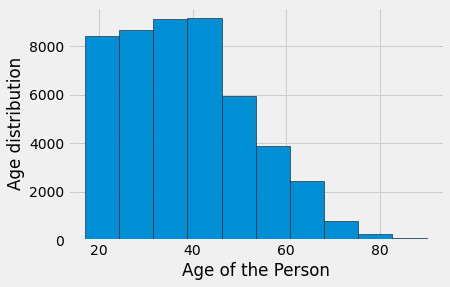

In [15]:
df['age'] = pd.to_numeric(df.age) # This is just done to make sure that every value in age is numeric.
plt.hist(x=df.age.values, edgecolor='black')
plt.xlabel("Age of the Person")
plt.ylabel("Age distribution")
plt.show()

# People of the age group of 20 to 40 were the majority of the people who participated in the survey.

In [16]:
min(df.age.values), max(df.age.values)

(17, 90)

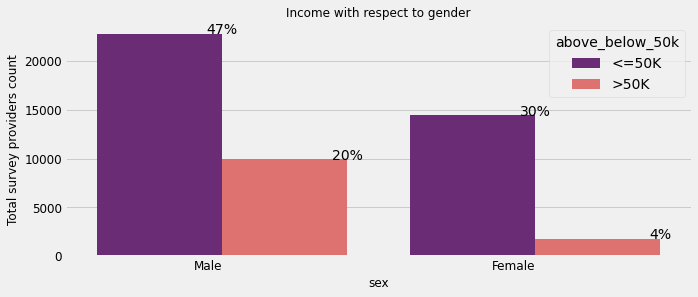

In [17]:
plt.figure(figsize =(10,4))
ax = sns.countplot(data = df, x = 'sex',hue = 'above_below_50k',palette='magma')
plt.xticks(size =12)
plt.xlabel('sex', size = 12)
plt.yticks(size = 12)
plt.ylabel('Total survey providers count', size = 12)
plt.title("Income with respect to gender", size = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

# 47% male & 30% female survey takers out of total earn <= 50000. 
# 20% male & 4% female survey takers out of total earn > 50000. 

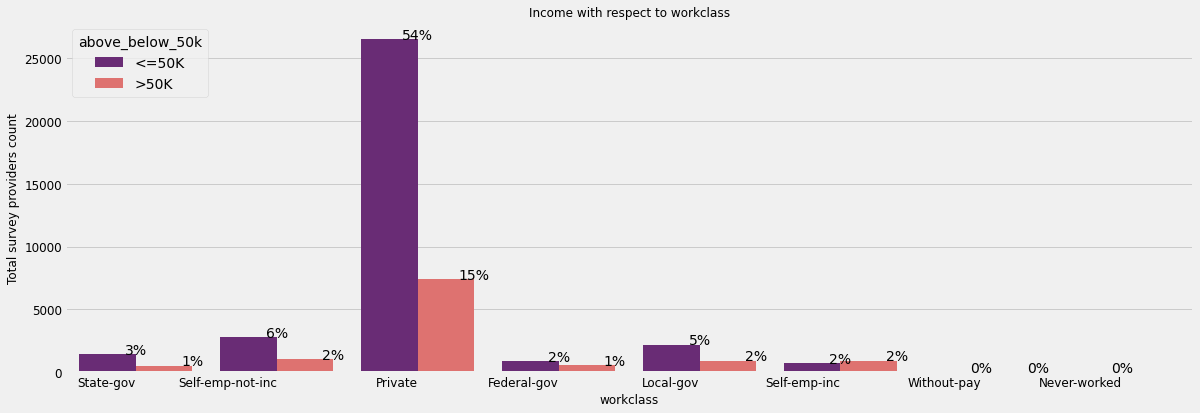

In [18]:
plt.figure(figsize =(18,6))
ax = sns.countplot(data = df, x = 'workclass',hue = 'above_below_50k',palette='magma')
plt.xticks(size =12)
plt.xlabel('workclass', size = 12)
plt.yticks(size = 12)
plt.ylabel('Total survey providers count', size = 12)
plt.title("Income with respect to workclass", size = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

# We can see that most people who gave survey worked in private organizations 
# 54% survey takers out of total earn <= 50000. 
# 15% survey takers out of total earn > 50000. 

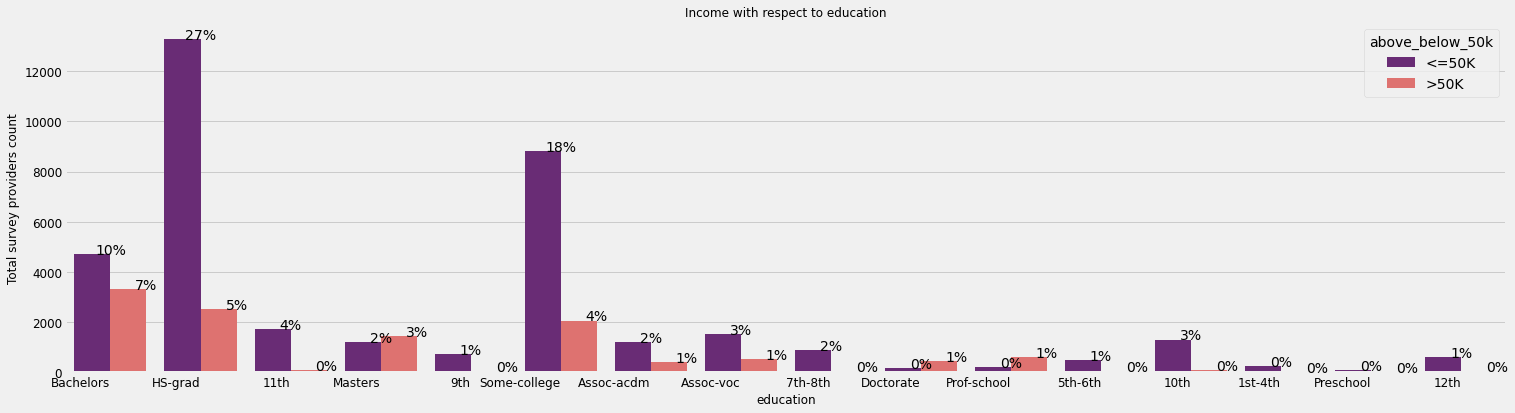

In [19]:
plt.figure(figsize =(23,6))
ax = sns.countplot(data = df, x = 'education',hue = 'above_below_50k',palette='magma')
plt.xticks(size =12)
plt.xlabel('education', size = 12)
plt.yticks(size = 12)
plt.ylabel('Total survey providers count', size = 12)
plt.title("Income with respect to education", size = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

# We can see that most people who gave survey graduated in higher secondary following with some college.
# 45% survey takers who graduated from a higher secondary & some college out of total earn <= 50000  

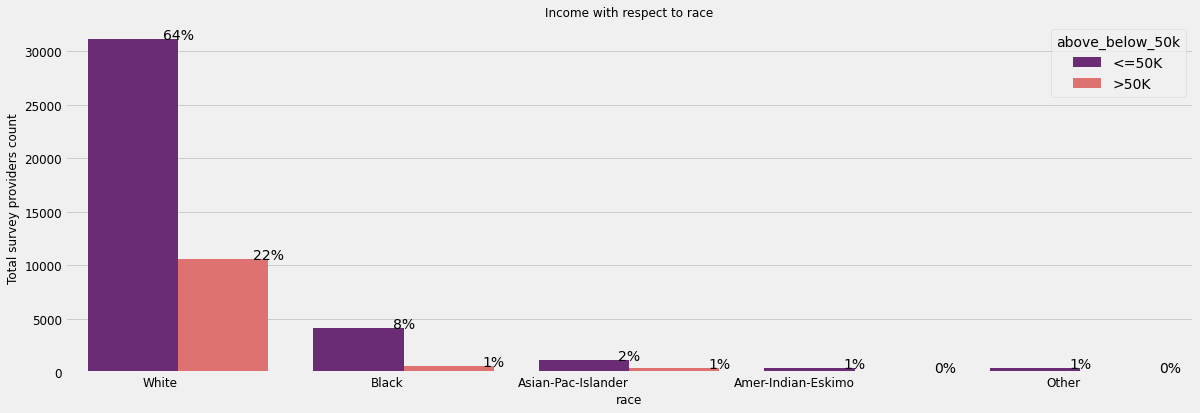

In [20]:
plt.figure(figsize =(18,6))
ax = sns.countplot(data = df, x = 'race',hue = 'above_below_50k',palette='magma')
plt.xticks(size =12)
plt.xlabel('race', size = 12)
plt.yticks(size = 12)
plt.ylabel('Total survey providers count', size = 12)
plt.title("Income with respect to race", size = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

# We can see that most people who gave survey are of white race & they contribute to 86% out of total population.

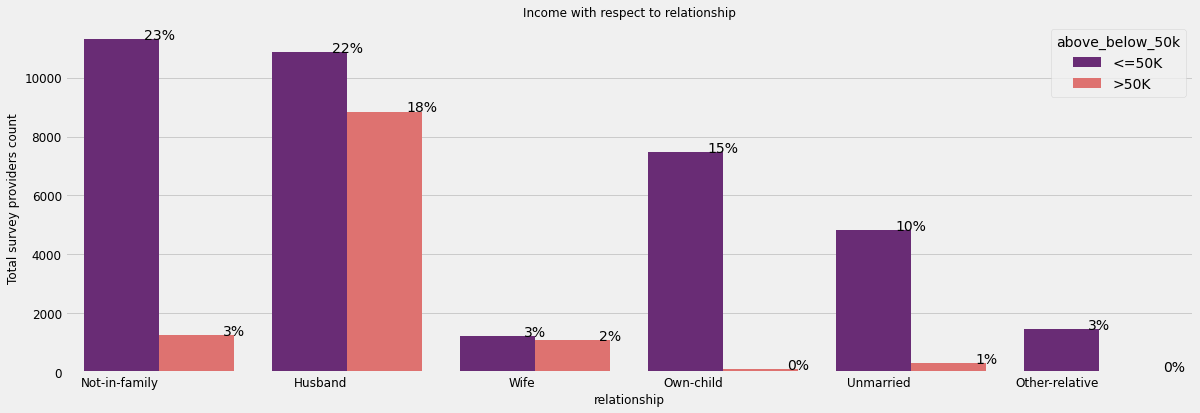

In [21]:
plt.figure(figsize =(18,6))
ax = sns.countplot(data = df, x = 'relationship',hue = 'above_below_50k',palette='magma')
plt.xticks(size =12)
plt.xlabel('relationship', size = 12)
plt.yticks(size = 12)
plt.ylabel('Total survey providers count', size = 12)
plt.title("Income with respect to relationship", size = 12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right");

total = len(df)
for p in ax.patches:
    percentage = '{:.0f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

# We can see that most people who gave survey are husbands where 18% of them earn >50k.

In [22]:
cat_cols = [col for col in df.columns if df[col].dtype == 'object']
num_cols = [col for col in df.columns if df[col].dtype == 'int64']

In [23]:
cat_cols

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'country',
 'above_below_50k']

In [24]:
num_cols

['age']

In [25]:
for i in df.columns:
    if df[i].dtypes == 'object':
        unique_cat = len(df[i].unique())
        print("Feature '{i}' has {unique_cat} unique categories".format(i=i, unique_cat=unique_cat))

Feature 'workclass' has 9 unique categories
Feature 'education' has 16 unique categories
Feature 'marital_status' has 7 unique categories
Feature 'occupation' has 15 unique categories
Feature 'relationship' has 6 unique categories
Feature 'race' has 5 unique categories
Feature 'sex' has 2 unique categories
Feature 'country' has 42 unique categories
Feature 'above_below_50k' has 2 unique categories


In [26]:
# looking at unique values in categorical columns
for col in cat_cols:
    print(f"{col} has --->> {df[col].unique()} values\n")

workclass has --->> ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' nan
 'Self-emp-inc' 'Without-pay' 'Never-worked'] values

education has --->> ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th'] values

marital_status has --->> ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed'] values

occupation has --->> ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' nan
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv'] values

relationship has --->> ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative'] values

race has --->> ['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other'] values

sex has --->> ['Male' 'Female'] value

In [27]:
# defining functions to create plot on numerical variables
def violin(col):
    fig = px.violin(df, y=col, x="above_below_50k", color="above_below_50k", box=True, template = 'plotly_dark')
    return fig.show()

In [28]:
violin('age')
# People who earn >50k are moreover of age 40 to 50 years.
# People who earn <50k are moreover of age 20 to 35 years.

### ----->>> Data Preprocessing --------->>>

### Missing value treatment

In [29]:
def find_missing_percent(data):
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])),ignore_index=True)
    return miss_df

In [30]:
miss_df = find_missing_percent(df)
miss_df

,ColumnName,TotalMissingVals,PercentMissing
0,age,0.0,0.00
1,workclass,2799.0,5.73
2,fnlgwt,0.0,0.00
3,education,0.0,0.00
4,education_num,0.0,0.00
5,marital_status,0.0,0.00
6,occupation,2809.0,5.75
7,relationship,0.0,0.00
8,race,0.0,0.00
9,sex,0.0,0.00


In [31]:
modes = df.mode().iloc[0]
df.fillna(modes, inplace=True)
# There are very little values missing in the data. Since the three columns where there are missing values are categorical, 
# looking at their distribution plots we can go for Mode value imputation

In [32]:
find_missing_percent(df)

,ColumnName,TotalMissingVals,PercentMissing
0,age,0.0,0.0
1,workclass,0.0,0.0
2,fnlgwt,0.0,0.0
3,education,0.0,0.0
4,education_num,0.0,0.0
5,marital_status,0.0,0.0
6,occupation,0.0,0.0
7,relationship,0.0,0.0
8,race,0.0,0.0
9,sex,0.0,0.0


### Applying binning on age & education variable - 

In [33]:
df['age'].min()

17

In [34]:
df['age'].max()

90

In [35]:
# Convertion of the continous variables to categorical 
bins= [17,30,60,90]  
labels = ['Young_age','Middle_age','old_age']
df['age'] = pd.cut(df['age'], bins=bins, labels=labels)

In [36]:
df['age'] = pd.Categorical(df.age)

In [37]:
df['education'].value_counts().sort_values()

Preschool          83
1st-4th           247
5th-6th           509
Doctorate         594
12th              657
9th               756
Prof-school       834
7th-8th           955
10th             1389
Assoc-acdm       1601
11th             1812
Assoc-voc        2061
Masters          2657
Bachelors        8025
Some-college    10878
HS-grad         15784
Name: education, dtype: int64

In [38]:
df['education_num'].value_counts().sort_values()

1.0        83
2.0       247
3.0       509
16.0      594
8.0       657
5.0       756
15.0      834
4.0       955
6.0      1389
12.0     1601
7.0      1812
11.0     2061
14.0     2657
13.0     8025
10.0    10878
9.0     15784
Name: education_num, dtype: int64

In [39]:
# Since these two columns are representing the same data on education, we can ignore any one of them.
del df['education']

In [40]:
bins= [0,6,11,16] 
labels = ['LOW','MIDDLE','HIGH']
df['education_num'] = pd.cut(df['education_num'], bins=bins, labels=labels)
df['education_num'] = pd.Categorical(df.education_num)

##### Looking at the survey taker's industry & categorizing them under a specific age group.

<AxesSubplot:xlabel='workclass'>

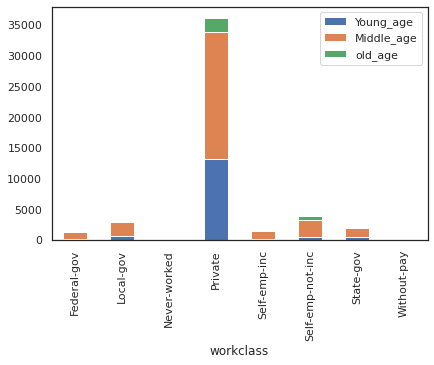

In [41]:
df.workclass = df.workclass.astype('category')
res = df.groupby('workclass').age.value_counts()
sns.set(style='white')
res.unstack().plot(kind='bar', stacked=True) #create stacked bar chart

# People working in private class are more with most of them under 30s following with 20s.

In [42]:
del df['fnlgwt'] # Final Weight is the number of people the census believes the entry represents.
# It won't create an impact in prediction of the income of a person hence removing this variable.

##### Analysing variables such as capital gain & capital loss.

In [43]:
violin('capital_gain') # We can see that the capital gain for most of the individuals who provided the survey is 0.
# Hence we can drop this variable from our analysis too.

In [44]:
violin('capital_loss')
# We can see that the capital loss for most of the individuals who provided the survey is 0.
# Hence we can drop this variable from our analysis too.

In [45]:
del df['capital_gain']
del df['capital_loss']

### Outlier treatment

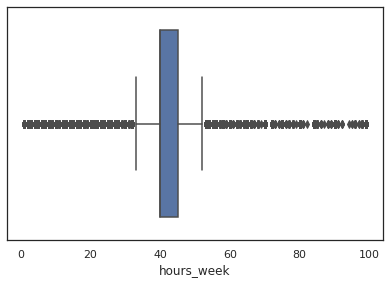

In [46]:
#Dealing with outliers.
for i in df.describe().columns:
    sns.boxplot(df[i].dropna())
    plt.show()
# Let's keep the outlier values as of now for the analysis.

In [47]:
def outlier_thresholds(dataframe, variable):
    quantile1 = dataframe[variable].quantile(0.25)
    quantile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interquantile_range
    low_limit = quantile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [48]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit

In [49]:
replace_with_thresholds(df,"hours_week")

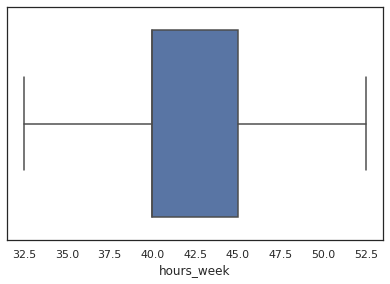

In [50]:
for i in df.describe().columns:
    sns.boxplot(df[i].dropna())
    plt.show()

### Dealing with categorical columns

In [51]:
violin('hours_week')
# Most of the people earning <=50k are of age 40.
# Most of the people earning >=50k are between age 40 to 50.

In [52]:
hours_group = []
for hour in df.hours_week:
    if hour < 40:
        hours_group.append('<40')
    elif hour == 40:
        hours_group.append('40')
    elif hour > 40:
        hours_group.append('>40')

In [53]:
df['hours_week'] = hours_group

In [54]:
df['hours_week'].value_counts()

40     22803
>40    14352
<40    11687
Name: hours_week, dtype: int64

In [55]:
df.hours_week = df.hours_week.astype('category')
df.relationship = df.relationship.astype('category')

In [56]:
race_list = []
for race in df.race:
    if race == 'White':
        race_list.append('White People')
    else:
        race_list.append('Non white people')

In [57]:
df['race'] = race_list

In [58]:
df['race'].value_counts()

White People        41762
Non white people     7080
Name: race, dtype: int64

In [59]:
Work_class_list = []
for workclass in df.workclass:
    if workclass == 'Private':
        Work_class_list.append('PRIVATE')
    else:
        Work_class_list.append('NON PRIVATE')

In [60]:
df['workclass'] = Work_class_list

In [61]:
df['workclass'].value_counts()

PRIVATE        36705
NON PRIVATE    12137
Name: workclass, dtype: int64

In [62]:
countries_list = []
for country in df.country:
    if country == "United-States":
        countries_list.append('US')
    else:
        countries_list.append('Not US')

In [63]:
df['country'] = countries_list

In [64]:
df['country'].value_counts()

US        44689
Not US     4153
Name: country, dtype: int64

In [65]:
import re
def occupation_based_on_skills(x):
    if re.search('managerial', x):
        return 'Leader'
    elif re.search('specialty',x):
        return 'Leader'
    else:
        return 'Not_Leader'

In [66]:
df['occupation']=df.occupation.apply(lambda x: x.strip()).apply(lambda x: occupation_based_on_skills(x))

In [67]:
df['occupation'].value_counts()

Not_Leader    33775
Leader        15067
Name: occupation, dtype: int64

In [68]:
marital_status_list = []
for i in df.marital_status:
    if i == 'Married-civ-spouse' or i == 'Married-spouse-absent' or i == 'Married-AF-spouse':
        marital_status_list.append('MARRIED')
    elif i == 'Never-married' or i == 'Divorced' or i == 'Separated' or i == 'Widowed':
        marital_status_list.append('NON-MARRIED')

In [69]:
df['marital_status']=marital_status_list

In [70]:
cat_cols_new = [col for col in df.columns if df[col].dtype == 'object']

In [71]:
for col in cat_cols_new:
    print(f"{col} has --->> {df[col].unique()} values\n")

workclass has --->> ['NON PRIVATE' 'PRIVATE'] values

marital_status has --->> ['NON-MARRIED' 'MARRIED'] values

occupation has --->> ['Not_Leader' 'Leader'] values

race has --->> ['White People' 'Non white people'] values

sex has --->> ['Male' 'Female'] values

country has --->> ['US' 'Not US'] values

above_below_50k has --->> ['<=50K' '>50K'] values



In [72]:
df['above_below_50k'].value_counts()

<=50K    37155
>50K     11687
Name: above_below_50k, dtype: int64

In [73]:
# Create a label encoder object
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            # Train on the training data
            le.fit(df[col])
            # Transform both training and testing data
            df[col] = le.transform(df[col])
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

7 columns were label encoded.


In [74]:
df['above_below_50k'].value_counts()

# Target variable encoding - 
# >50k -->> 1 
# <= 50k -->> 0

0    37155
1    11687
Name: above_below_50k, dtype: int64

In [75]:
# one-hot encoding of categorical variables
df = pd.get_dummies(df)
print('Features shape:', df.shape)

Features shape: (48842, 22)


In [76]:
df.columns = [column.lower().replace(" ", "_").replace("-", "_") for column in df.columns]
df.rename(columns = {'hours_week_<40':'hours_week_less_than_40', 'hours_week_>40':'hours_week_more_than_40'}, inplace = True)

In [77]:
df.head()

,workclass,marital_status,occupation,race,sex,country,above_below_50k,age_young_age,age_middle_age,age_old_age,education_num_low,education_num_middle,education_num_high,relationship_husband,relationship_not_in_family,relationship_other_relative,relationship_own_child,relationship_unmarried,relationship_wife,hours_week_40,hours_week_less_than_40,hours_week_more_than_40
0,0,1,1,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0
1,0,0,0,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0
2,1,1,1,1,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0
3,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0


### Correlation plot

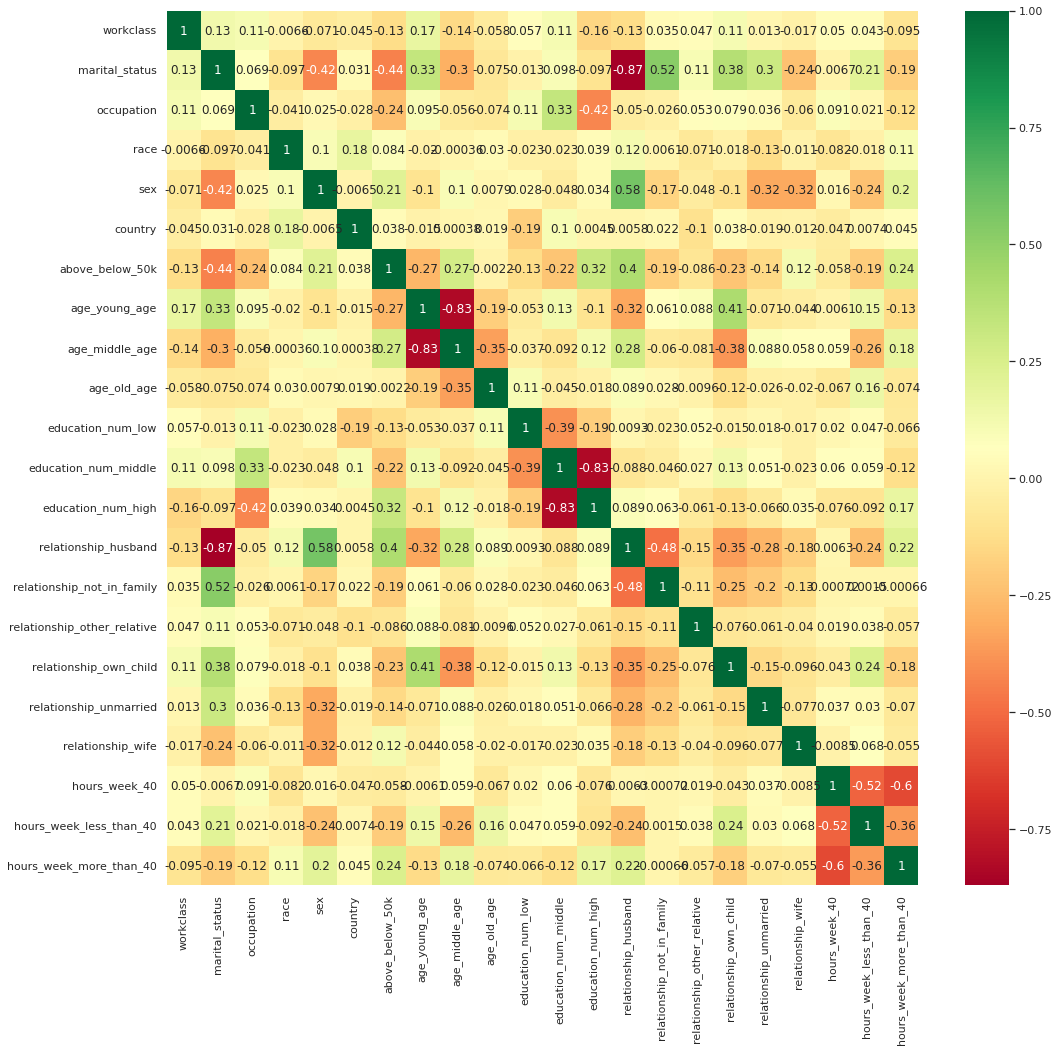

In [78]:
import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Using correlation analysis results we cannot eliminate any such variable & it is difficult to generate any insights too.

### Checking on data imbalance

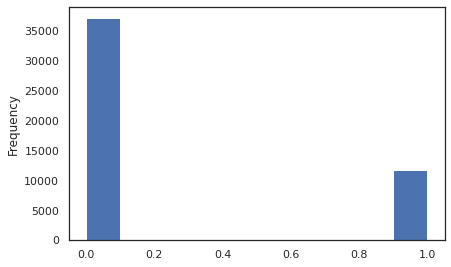

In [79]:
df['above_below_50k'].astype(int).plot.hist(); # Highly imbalanced dataset

#### A combination of under- and oversampling method using pipeline

In [80]:
import numpy as np
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean

train = df[:32561]
test = df[32562:]

x_train = train.drop('above_below_50k',axis=1) 
y_train = train['above_below_50k'].values 
x_test = test.drop('above_below_50k',axis=1) 
y_test = test['above_below_50k'].values

# define pipeline
model = SVC()
over = SMOTE(sampling_strategy=0.4,random_state=7)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=7)
steps = [('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# evaluate pipeline
scores = cross_val_score(pipeline,x_train, y_train, scoring='roc_auc', cv=5, n_jobs=-1)
score = mean(scores)
print('ROC AUC score for the combined sampling method: %.3f' % score)

ROC AUC score for the combined sampling method: 0.838


 #### Oversampling with SMOTE

In [81]:
from collections import Counter
train = df[:32561]
test = df[32562:]
print(len(train), len(train_df), len(test), len(test_df))

x_train = train.drop('above_below_50k',axis=1) 
y_train = train['above_below_50k'].values 
x_test = test.drop('above_below_50k',axis=1) 
y_test = test['above_below_50k'].values 

# summarize class distribution
print("Before oversampling: ",Counter(y_train))

# define oversampling strategy
SMOTE = SMOTE(sampling_strategy=0.7, random_state=7)

# fit and apply the transform
x_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(x_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_SMOTE = model.fit(x_train_SMOTE, y_train_SMOTE)
pred_SMOTE = clf_SMOTE.predict(x_test)

print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))

32561 32561 16280 16282
Before oversampling:  Counter({0: 24720, 1: 7841})
After oversampling:  Counter({0: 24720, 1: 17304})
ROC AUC score for oversampled SMOTE data:  0.8013827099649854


##### To deal with data imbalnce we are doing oversampling using smote where the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.

### Feature Importance

##### SelectKbest is a method provided by sklearn to rank features of a dataset by their “importance ”with respect to the target variable. This “importance” is calculated using a score function such as - [chi2]: Chi-squared stats of non-negative features for classification tasks.

In [82]:
from sklearn.feature_selection import SelectKBest #Chi-squared test is applicable only for categorical data
from sklearn.feature_selection import chi2
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(x_train_SMOTE, y_train_SMOTE)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x_train_SMOTE.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                         Specs        Score
1               marital_status  6096.528805
12        relationship_husband  4572.584573
6                age_young_age  3449.623326
11          education_num_high  3295.384615
15      relationship_own_child  3200.872470
20     hours_week_more_than_40  2055.048405
19     hours_week_less_than_40  1826.841676
13  relationship_not_in_family  1758.426015
7               age_middle_age  1535.391436
16      relationship_unmarried  1245.827689


### Modelling

In [83]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

#### Building Decision Tree model 

In [84]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(x_train_SMOTE, y_train_SMOTE)

# Evaluate Model
dtc_eval = evaluate_model(dtc,x_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.7841523341523342
Precision: 0.5280121498481269
Recall: 0.8135725429017161
F1 Score: 0.6404011461318053
Area Under Curve: 0.859214729695831
Confusion Matrix:
 [[9637 2797]
 [ 717 3129]]


#### Building KNN model 

In [85]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(x_train_SMOTE, y_train_SMOTE)

# Evaluate Model
knn_eval = evaluate_model(knn, x_test, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.7838452088452088
Precision: 0.5338299193047796
Recall: 0.6708268330733229
F1 Score: 0.5945385413066022
Area Under Curve: 0.8257447999383702
Confusion Matrix:
 [[10181  2253]
 [ 1266  2580]]


#### Random forest model

In [86]:
rf = RandomForestClassifier(n_estimators=100, random_state=7)
rf.fit(x_train_SMOTE, y_train_SMOTE)

# Evaluate Model
rf_eval = evaluate_model(rf, x_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.7854422604422604
Precision: 0.5298293053912455
Recall: 0.8151326053042122
F1 Score: 0.6422206289050496
Area Under Curve: 0.868418071128507
Confusion Matrix:
 [[9652 2782]
 [ 711 3135]]


#### Gradient boosting model

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(learning_rate=0.1)
gb.fit(x_train_SMOTE, y_train_SMOTE)

# Evaluate Model
gb_eval = evaluate_model(gb, x_test, y_test)

# Print result
print('Accuracy:', gb_eval['acc'])
print('Precision:', gb_eval['prec'])
print('Recall:', gb_eval['rec'])
print('F1 Score:', gb_eval['f1'])
print('Area Under Curve:', gb_eval['auc'])
print('Confusion Matrix:\n', gb_eval['cm'])

Accuracy: 0.7881449631449632
Precision: 0.5334908047916315
Recall: 0.8221528861154446
F1 Score: 0.6470889184487874
Area Under Curve: 0.8782770218642105
Confusion Matrix:
 [[9669 2765]
 [ 684 3162]]


#### Building logistic regression model

In [88]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train_SMOTE, y_train_SMOTE)
# Evaluate Model
lr_eval = evaluate_model(lr, x_test, y_test)
# Print result
print('Accuracy:', lr_eval['acc'])
print('Precision:', lr_eval['prec'])
print('Recall:', lr_eval['rec'])
print('F1 Score:', lr_eval['f1'])
print('Area Under Curve:', gb_eval['auc'])
print('Confusion Matrix:\n', gb_eval['cm'])

Accuracy: 0.7913390663390664
Precision: 0.5394343931143509
Recall: 0.7984919396775871
F1 Score: 0.643883006604466
Area Under Curve: 0.8782770218642105
Confusion Matrix:
 [[9669 2765]
 [ 684 3162]]


#### Model Comparison

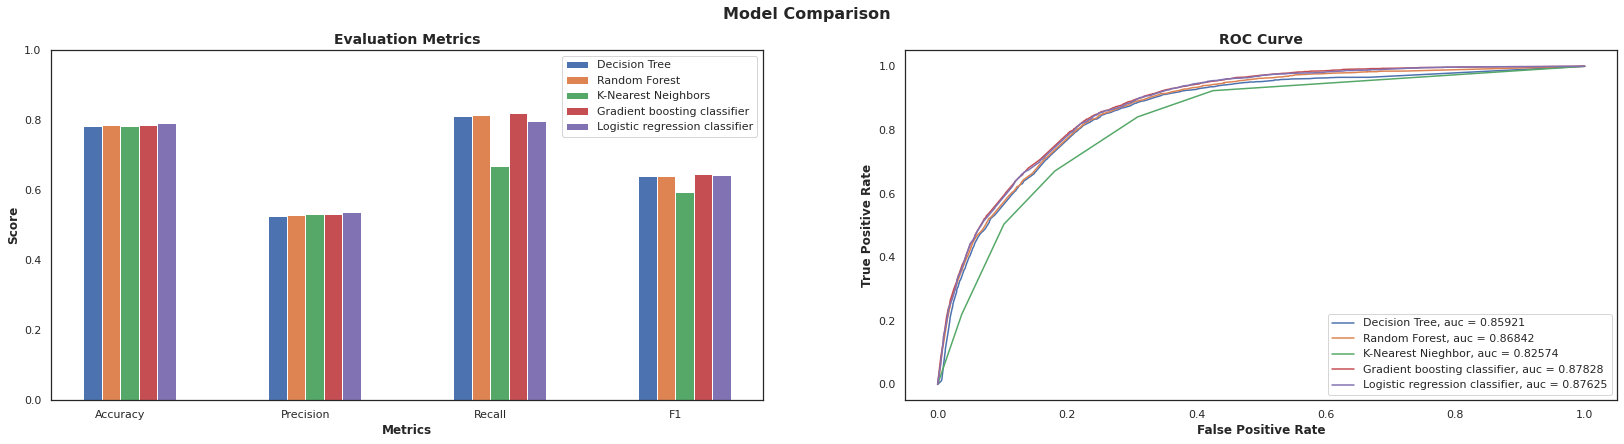

In [89]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(25)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.1
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1']]
gb_score = [gb_eval['acc'], gb_eval['prec'], gb_eval['rec'], gb_eval['f1']]
lr_score = [lr_eval['acc'], lr_eval['prec'], lr_eval['rec'], lr_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')
ax1.bar(r4, gb_score, width=barWidth, edgecolor='white', label='Gradient boosting classifier')
ax1.bar(r5, lr_score, width=barWidth, edgecolor='white', label='Logistic regression classifier')


## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))
ax2.plot(gb_eval['fpr'], gb_eval['tpr'], label='Gradient boosting classifier, auc = {:0.5f}'.format(gb_eval['auc']))
ax2.plot(lr_eval['fpr'], lr_eval['tpr'], label='Logistic regression classifier, auc = {:0.5f}'.format(lr_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

Question - Assess the performance of your models using appropriate metrics. Discuss which model is best and why.

Answer - Since we want to Predict if income exceeds 50,000 per year so in this case we can focus on "RECALL" as a metric of our model because in our problem we want to predict as many actual positive we can. Since misclassification of any person who actually earns more than 50,000 might loose the essence of the entire survey if the model starts predicting that person's income as less than 50,000. 

Hence as per my understanding & analysis taking RECALL as a final metric might work & definitely gradient boosting gives us the highest recall score with lowest false negative value in the confusion matrix so it needs to be optimized further for better results. 

### Model Optimisation-

##### Let us optimise our naive bayes model by tuning the hyper parameters available from the scikit-learn library. After finding the optimal parameters we will then evaluate our new model by comparing it against our base line model.

In [90]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
#gridsearch searches for the best hyperparameters and keeps the classifier with the highest recall score
xgb_model=XGBClassifier()
param_grid = { 'max_depth': [4,5,6] , 'min_child_weight':[4,5,6] ,'learning_rate': [0.05,0.1,0.5] ,'n_estimators': [20,50,100] }
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='recall') 
grid_search.fit(x_train_SMOTE, y_train_SMOTE)
grid_search.best_params_

{'learning_rate': 0.5,
 'max_depth': 6,
 'min_child_weight': 4,
 'n_estimators': 100}

### Evaluating Optimised Model-

##### After finding the best parameter for the model we can access the best_estimator_ attribute of the GridSearchCV object to save our optimised model into variable called best_grid. We will calculate the evaluation metrics to compare it with our base model on the next step.

In [91]:
# Select best model with best fit
best_grid = grid_search.best_estimator_

# Evaluate Model
best_grid_eval = evaluate_model(best_grid, x_test, y_test)

# Print result
print('Accuracy:', best_grid_eval['acc'])
print('Precision:', best_grid_eval['prec'])
print('Recall:', best_grid_eval['rec'])
print('F1 Score:', best_grid_eval['f1'])
print('Area Under Curve:', best_grid_eval['auc'])
print('Confusion Matrix:\n', best_grid_eval['cm'])

Accuracy: 0.787960687960688
Precision: 0.533310787960771
Recall: 0.8200728029121165
F1 Score: 0.646311475409836
Area Under Curve: 0.8733328302088172
Confusion Matrix:
 [[9674 2760]
 [ 692 3154]]


### Model Comparison-

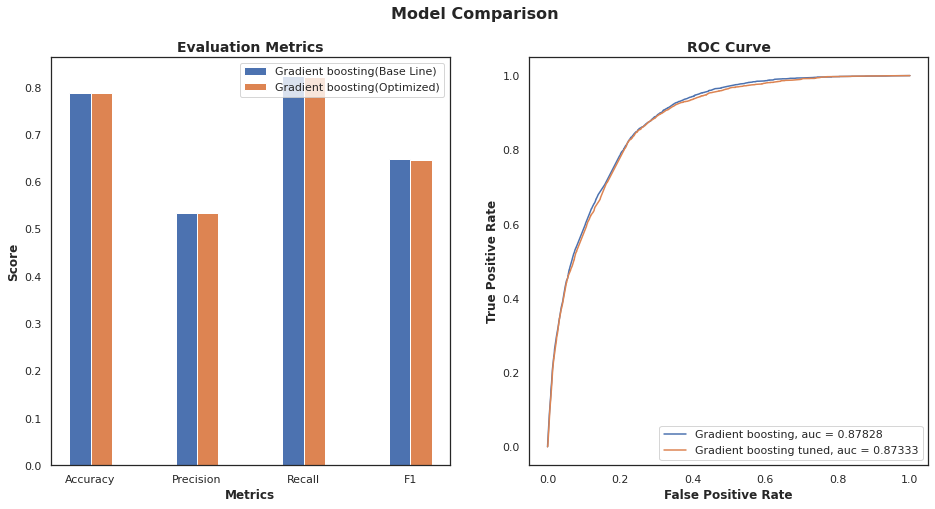

Change of -0.02% on accuracy.
Change of -0.03% on precision.
Change of -0.25% on recall.
Change of -0.12% on F1 score.
Change of -0.56% on AUC.


In [92]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
gb_score = [gb_eval['acc'], gb_eval['prec'], gb_eval['rec'], gb_eval['f1']]
best_grid_score = [best_grid_eval['acc'], best_grid_eval['prec'], best_grid_eval['rec'], best_grid_eval['f1']]

## Set position of bar on X axis
r1 = np.arange(len(gb_score))
r2 = [x + barWidth for x in r1]

## Make the plot
ax1.bar(r1, gb_score, width=barWidth, edgecolor='white', label='Gradient boosting(Base Line)')
ax1.bar(r2, best_grid_score, width=barWidth, edgecolor='white', label='Gradient boosting(Optimized)')

## Add xticks on the middle of the group bars
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
ax1.set_xticks([r + (barWidth * 0.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')

## Create legend & Show graphic
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(gb_eval['fpr'], gb_eval['tpr'], label='Gradient boosting, auc = {:0.5f}'.format(gb_eval['auc']))
ax2.plot(best_grid_eval['fpr'], best_grid_eval['tpr'], label='Gradient boosting tuned, auc = {:0.5f}'.format(best_grid_eval['auc']))

ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')
ax2.legend(loc=4)

plt.show()

print('Change of {:0.2f}% on accuracy.'.format(100 * ((best_grid_eval['acc'] - gb_eval['acc']) / gb_eval['acc'])))
print('Change of {:0.2f}% on precision.'.format(100 * ((best_grid_eval['prec'] - gb_eval['prec']) / gb_eval['prec'])))
print('Change of {:0.2f}% on recall.'.format(100 * ((best_grid_eval['rec'] - gb_eval['rec']) / gb_eval['rec'])))
print('Change of {:0.2f}% on F1 score.'.format(100 * ((best_grid_eval['f1'] - gb_eval['f1']) / gb_eval['f1'])))
print('Change of {:0.2f}% on AUC.'.format(100 * ((best_grid_eval['auc'] - gb_eval['auc']) / gb_eval['auc'])))

We can see that tuned xgboost model is of no use as there is decrease in recall evaluation metric.
Hence we can work with the first xg boost model to generate the desired predictions.

##### Model explainability using shap explainable AI --->

The SHAP framework has proved to be an important advancement in the field of machine learning model interpretation.
SHAP explains predictions for any model.SHAP values quantify the magnitude and direction (positive or negative) of a feature’s effect on a prediction.

In [93]:
# compute SHAP values
explainer = shap.TreeExplainer(gb) 
shap_values = explainer.shap_values(x_train)
explainer = shap.Explainer(gb)
shap_values = explainer(x_train)

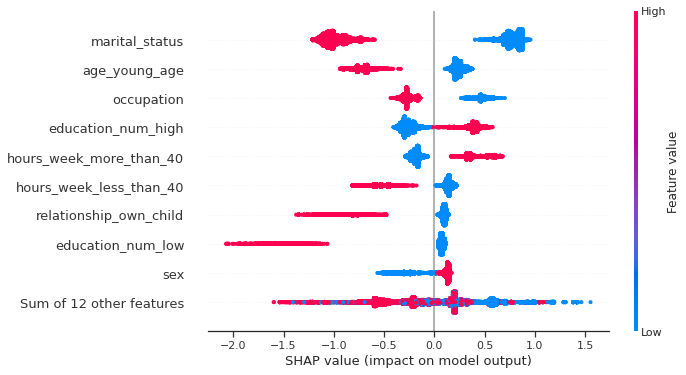

In [94]:
shap.plots.beeswarm(shap_values)

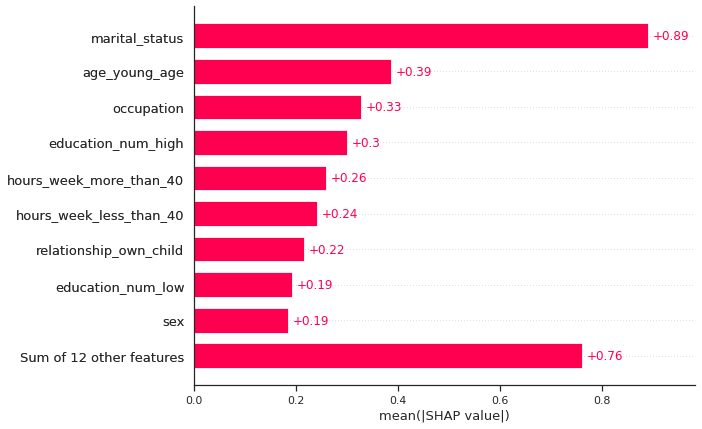

In [95]:
shap.plots.bar(shap_values)
# We can see that the variable marital status , people of young age , occupation , High degrees , working hours 
# are the deciding factors towards, predicting people whose income is >50K.

In [96]:
train_df['income_prediction'] = gb.predict(x_train)
train_df['income_prediction'] = train_df['income_prediction'].apply(lambda x: '<=50K' if x==0 else '>50K')
train_df.head(10)

,Age,Workclass,fnlgwt,Education,Education Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Country,Above/Below 50K,income_prediction
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,>50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,>50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,>50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K,>50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K,>50K


In [97]:
# Save new dataframe into csv file
train_df.to_csv('income_prediction.csv', index=False)

## ---- End of code ---

Business problem to be solved and analysis of the outcomes - 

###### Problem statement - Predicting if income exceeds 50,000 per year based on 1994 US Census Data with Simple Classification Techniques.

###### Insights found - 

    1.People of the age group of 20 to 50 were the majority of the people who participated in the survey.
    People who earn >50k are moreover of age 40 to 50 years & those who earn <50k are moreover of age 20 to 35 years.

    2.we can see that there is almost double the sample size of males in comparison to females in the dataset. 
    The percentage of males who make greater than 50,000 is much greater than the percentage of females that 
    make the same amount. This will certainly be a significant factor considered as an important in our prediction model.

    3.majority of the individuals work in the private sector.Federal government is seen as the most elite
    in the public sector, which most likely explains the higher chance of earning more than 50,000.

    4.For the most part, a higher level of education is correlated to a higher percentage of
    individuals with the label >50k. One interesting statistic to note is the ratio of 
    individuals labeled >50k to <=50k is almost the same between those that have a doctorate and those that
    went to a professional school.

    5.Since we want to Predict if income exceeds 50,000 per year so in this case we can focus on "RECALL" 
    as a metric of our model because in our problem we want to predict as many actual positive we can. 
    Since misclassification of any person who actually earns more than 50,000 might loose the essence 
    of the entire survey if the model starts predicting that person's income as less than 50,000.

The positive drivers towards predicting if income exceeds 50,000 for any survey taker are as follows - 

This was identified using SHAP.

Marital_status , young age survey takers , occupation , Higher/Lower education degree,
working hours of that person , gender of that person ,if he is an own child.

##### NOTE - For a simple model we can see that our model did decently on classifying the data. 
###### But there are still some weakness on our model, especially shown on the recall metric where we only get about approx 80%.
###### This means that our model are only able to detect 80% of potential customer and miss the other 20%.
##### The result is not that much different after optimising the model too.
##### To improve our performance we can try to look into another algorithm such as Naive bayes.